# QKeras RNN comparison


1. Create a model and compare its performance to the boosted model
2. If the model outreach the performance of the boosted model : 
 -   create a model with the same feature with qkeras (QAT) and 
 -   quantized the keras model (PTQ)
3. Compare those two to PTQ boosted model

The models with keras should converge to around 1e-5 or 9.8e-6

For QKeras it's been somewhere around 1.1e-5 or so



# To Run Everytime

## Imports

In [8]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from collections import deque


from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml


2022-05-24 14:21:19.892366: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-05-24 14:21:19.898212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-24 14:21:19.898228: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


name convert optimizers ['fuse_bias_add', 'remove_useless_transpose', 'output_rounding_saturation_mode', 'qkeras_factorize_alpha', 'extract_ternary_threshold', 'fuse_consecutive_batch_normalization'] File: flow.py Line: 23
name optimize optimizers ['eliminate_linear_activation', 'fuse_consecutive_batch_normalization', 'fuse_batch_normalization', 'replace_multidimensional_dense_with_conv'] File: flow.py Line: 23
vivado:merge_batch_norm_quantized_tanh Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:quantize_dense_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_config_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:optimize_pointwise_conv Get_Optimizer, optimizer/opti

/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [9]:
# Load libraries if they are changed
%load_ext autoreload
%autoreload 2


## Settings

In [10]:
# settings of the networks 
output = 1

nbr_batch = 64
nbr_epoch = 200
lr=0.001

time_step = 50
nbr_conv_epoch = 4 #number of epochs for the conversion 

patience_es = 12
patience_rlr = 5
delta = 0.0000001

def version(v): return (v)
versions_range = 10

def units(j): return (j+8)
units_range = 1

In [11]:
#quantized settings
integer = 0

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+8)

def bit_width(i): return {'bits': (i+8), 'integer': integer, 'symmetric': 0, 'alpha':1}

bits_range = 1

In [12]:
# path

#path of the tested models 
def models_path(v) : return f"tests/models/model_timestep={time_step}_v{version(v)}.h5"

#path of the qconverted models
def qmodels_path(j, i): return f"tests/qmodels_test/qconverted/qmodels_units={units(j)}_epoch={nbr_conv_epoch}_batch={nbr_batch}_lr={lr}_patiencES={patience_es}_patienceRLR={patience_rlr},<{bit_lenghts(i)},{integer}>.h5"

#path of the qtrained models
def qtrained_models_path(j, i, v ): return f"tests/qmodels_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_patiencES={patience_es}_patienceRLR={patience_rlr}_delta={delta}_cp,<{bit_lenghts(i)},{integer}>v{version(v)}.h5"

#path of the qref models 
def qrefmodels_path (i) : return f"qmodels_epoch={nbr_conv_epoch}/qmodels<{bit_lenghts(i)},{integer}>.h5"

## Data creation 

In [13]:
import importlib

path_to_datashaper = f"datashapers.datashaper_{time_step}"
mymodule = importlib.import_module(path_to_datashaper)

ds = mymodule.DataShaper.from_h5("../data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()

shapes (1999950, 50, 1) (1999950, 1)
shapes (899927, 50, 1) (99948, 50, 1) (999975, 50, 1)


# 1. Classic Network


## Training of the classic model

In [14]:
import os

In [15]:
def normal_model (units_parameter):
    
    checkpoint_filepath = '/atlas/bonnet/Desktop/code/internship_CPPM/rnn/model_checkpoint'

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=patience_es, 
                                                    restore_best_weights=True, 
                                                    min_delta=delta,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=patience_rlr, min_lr=0.000001, min_delta=delta, verbose=1)

    val_loss = 1


    # restart training if the model does not start converging by the end of first epoch
    while val_loss > 0.0005:
        print("testing new weights")
        r_model = Sequential()
        r_model.add(SimpleRNN(units_parameter, activation='relu', input_shape=(time_step, 1), return_sequences=False, name='SimpleRNN'))
        r_model.add(Dense(output, activation='relu',name='dense'))
        r_model.compile(loss="mean_squared_error", optimizer=Adam(lr))
        history = r_model.fit(x,y,validation_data=(x_val,y_val), epochs=1, batch_size=nbr_batch, shuffle=True, callbacks=[early_stopping, reduce_lr])
        val_loss = history.history['val_loss'][0]


    r_model.summary()

    hist = r_model.fit(x,y,validation_data=(x_val,y_val), epochs=nbr_epoch, batch_size=nbr_batch, shuffle=True, callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title(models_path(101))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return r_model

def model_training (): 
    models =[]

    for j in range(units_range):
        units_parameter = units(j)
        for v in range(versions_range):

            if (os.path.exists(models_path(v))==False):
                model = normal_model(units_parameter)
                models.append(model)
                model.save(models_path(v))
                print('number of units ', units_parameter)  
            else : print(f'{models_path(v)} already exists')       
    return models

models = model_training()

tests/models/model_timestep=50_v0.h5 already exists
testing new weights


2022-05-24 14:21:30.451823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-24 14:21:30.451866: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-24 14:21:30.451894: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martop): /proc/driver/nvidia/version does not exist
2022-05-24 14:21:30.452457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


14062/14062 [==============================] - 164s 12ms/step - loss: 1.7650e-05 - val_loss: 1.2627e-05 - lr: 0.0010
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SimpleRNN (SimpleRNN)       (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14062/14062 [==============================] - 154s 11ms/step - loss: 1.1994e-05 - val_loss: 1.1831e-05 - lr: 0.0010
Epoch 2/200
14062/14062 [==============================] - 142s 10ms/step - loss: 1.1610e-05 - val_loss: 1.1767e-05 - lr: 0.0010
Epoch 3/200
14062/14062 [==============================] - 145s 10ms/step - loss:

In [ ]:

for i, layer in enumerate (models[0].layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')

0 <keras.layers.rnn.simple_rnn.SimpleRNN object at 0x7f85d46fed90>
     <function tanh at 0x7f8602827320>
1 <keras.layers.core.dense.Dense object at 0x7f85d46fe2d0>
     <function relu at 0x7f8602822f80>


# 2. Quantizing it 

## Quantization conversion

In [13]:
def quantized_conv_model (bits, units_parameter, model_to_convert):  


    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=patience_es, 
                                                    restore_best_weights=True, 
                                                    min_delta=0.000001,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=patience_rlr, min_lr=0.000001, verbose=1) 
    qr_model = Sequential()

    qr_model.add(QSimpleRNN(units_parameter,
                        input_dim= 1,
                        activation='relu',
                        kernel_quantizer=quantized_bits(**bits),
                        recurrent_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)    
                        ))
       
    qr_model.add(QDense(output, 
                        activation='relu',
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits) ))

    qr_model.compile(loss="mse", optimizer=Adam(lr))
    
    qr_model.summary()
    #using the weight from the classic network as a base
    qr_model.set_weights(model_to_convert.get_weights())
    qr_model.fit(x, y, validation_data= (x_val,y_val),epochs = nbr_conv_epoch, batch_size=nbr_batch, shuffle=True, callbacks=[early_stopping, reduce_lr])

    return qr_model

def qmodel_conv_training (): 

    qmodels =[]
    for i in range(bits_range):
        bits_parameter = bit_width(i)
        for j in range(units_range):
            if (os.path.exists(qmodels_path(j,i))==False):
                qmodel = quantized_conv_model(bits_parameter, units(j), tf.keras.models.load_model(models_path(j)))
                qmodel.save(qmodels_path(j,i))
                qmodels.append(qmodel)
            else : print(f'{qmodels_path(j,i)} already exists')
        print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_conv_training()

OSError: No file or directory found at tests/models_test/epochs=200/models_units=4_batch=32_lr=0.001_patiencES=8_patienceRLR=5.h5

31250/31250 [==============================] - 32s 1ms/step


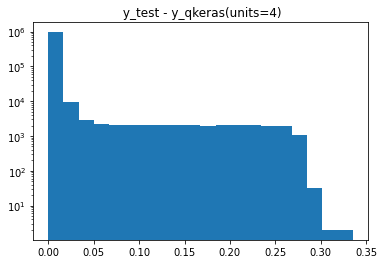

31250/31250 [==============================] - 32s 1ms/step


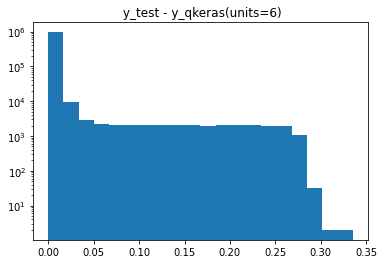

31250/31250 [==============================] - 33s 1ms/step


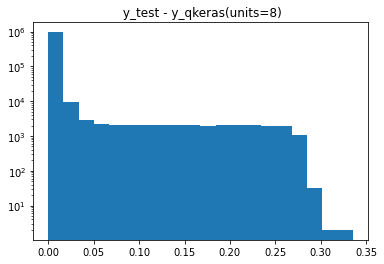

31250/31250 [==============================] - 33s 1ms/step


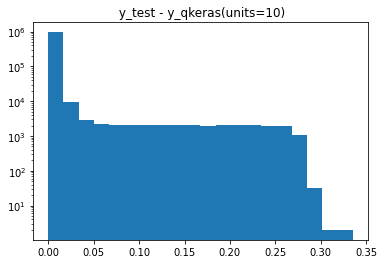

31250/31250 [==============================] - 32s 1ms/step


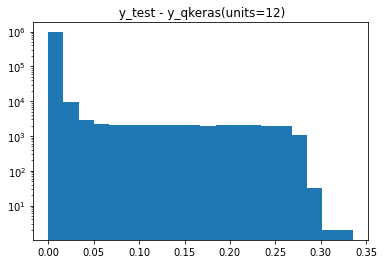

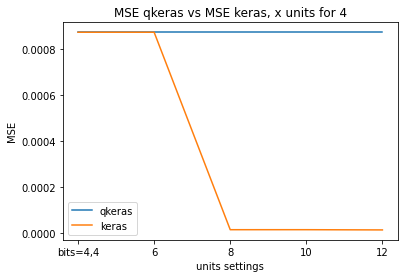

31250/31250 [==============================] - 34s 1ms/step


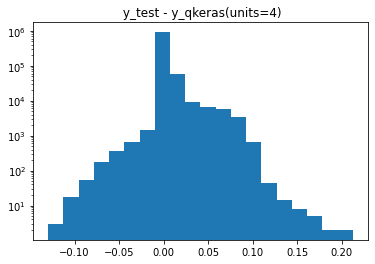

31250/31250 [==============================] - 33s 1ms/step


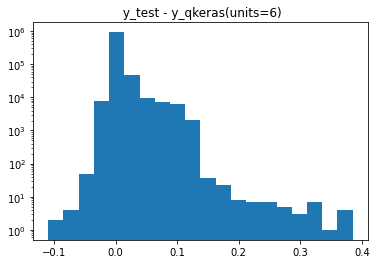

31250/31250 [==============================] - 33s 1ms/step


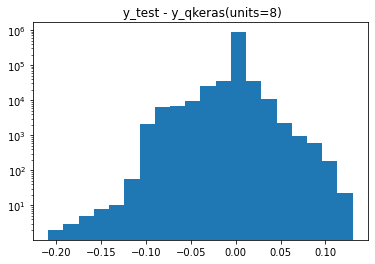

31250/31250 [==============================] - 34s 1ms/step


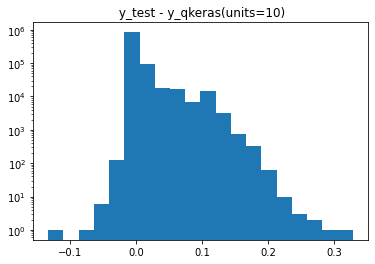

31250/31250 [==============================] - 32s 1ms/step


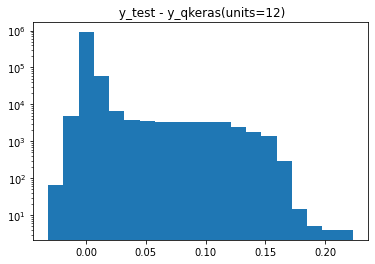

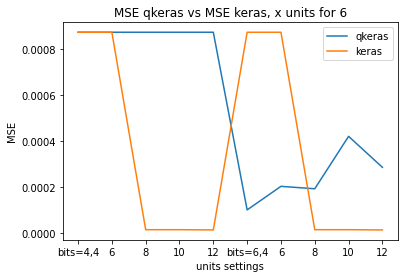

31250/31250 [==============================] - 34s 1ms/step


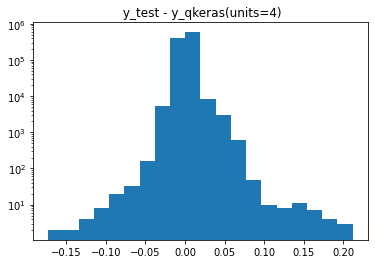

31250/31250 [==============================] - 34s 1ms/step


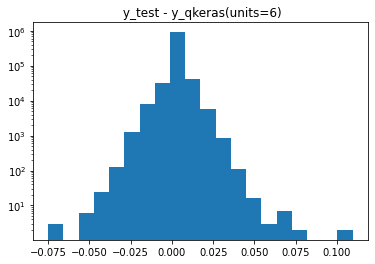

31250/31250 [==============================] - 35s 1ms/step


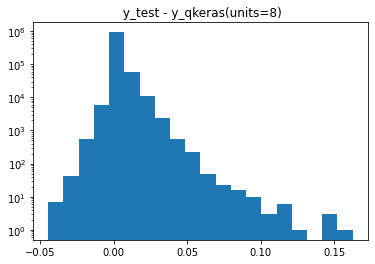

31250/31250 [==============================] - 34s 1ms/step


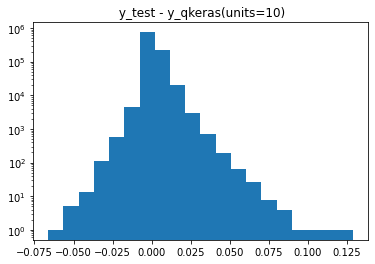

31250/31250 [==============================] - 34s 1ms/step


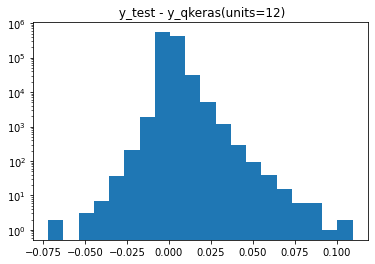

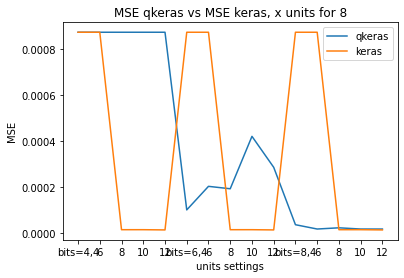

31250/31250 [==============================] - 35s 1ms/step


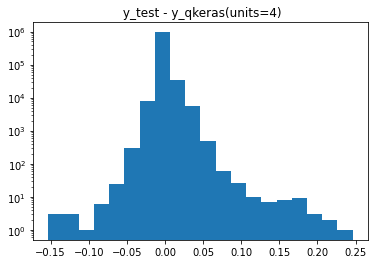

31250/31250 [==============================] - 38s 1ms/step


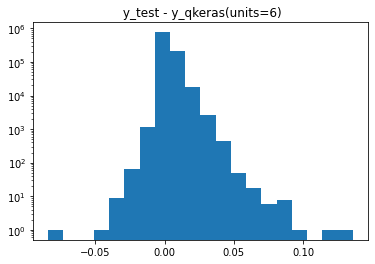

31250/31250 [==============================] - 33s 1ms/step


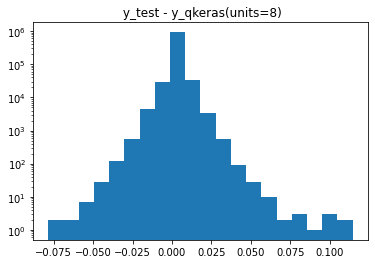

31250/31250 [==============================] - 34s 1ms/step


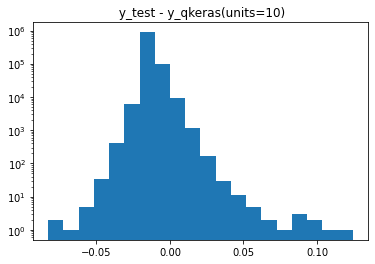

31250/31250 [==============================] - 33s 1ms/step


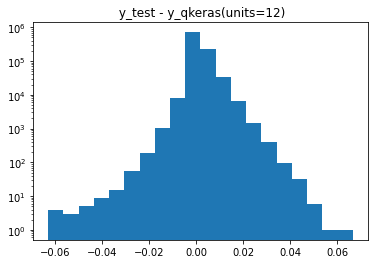

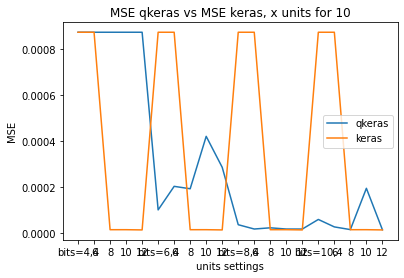

31250/31250 [==============================] - 36s 1ms/step


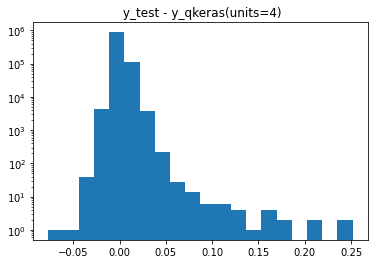

31250/31250 [==============================] - 33s 1ms/step


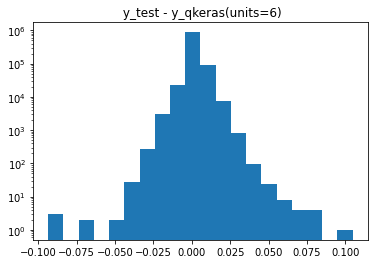

31250/31250 [==============================] - 37s 1ms/step


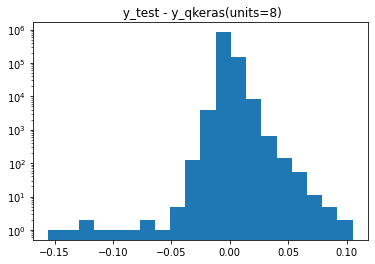

31250/31250 [==============================] - 34s 1ms/step


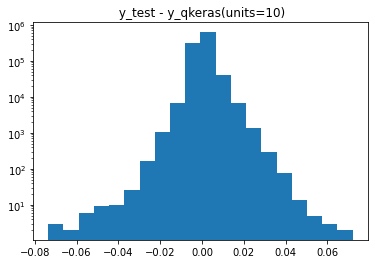

31250/31250 [==============================] - 36s 1ms/step


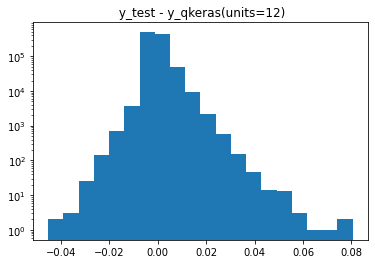

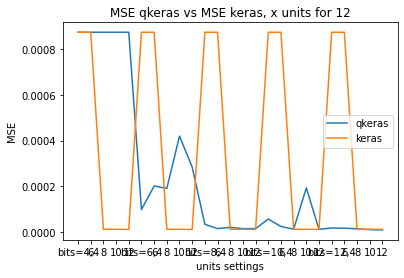

In [10]:
bit_nbr = []
loss1 = [] 
loss2 = []
unit_nbr = []

for i in range(bits_range):

    bit_nbr.append(bit_lenghts(i))
    for j in range (units_range):
        if (j==0):
            unit_nbr.append(f'bits={bit_lenghts(i)},{units(j)}')
        else: 
            unit_nbr.append(f'{units(j)}')
        qmodel = qkeras.utils.load_qmodel(qmodels_path(j,i))        
        y_qkeras = qmodel.predict(x_test)
        model = tf.keras.models.load_model(models_path(j))
        y_keras = model.predict(x_test)

        loss1.append(mse(y_test,y_qkeras))        
        loss2.append(mse(y_test,y_keras))

        plt.figure()
        plt.hist(y_test-y_qkeras, bins=20)
        plt.yscale('log')
        plt.title(f' y_test - y_qkeras(units={units(j)})')
        plt.show()
        
    plt.figure()
    plt.plot(loss1)
    plt.plot(loss2)
    plt.legend(['qkeras','keras'])
    plt.xticks(np.arange(len(unit_nbr)), [f"{unit}" for unit in unit_nbr])
    plt.xlabel('units settings')
    plt.ylabel('MSE')
    plt.title(f'MSE qkeras vs MSE keras, x units for {bit_lenghts(i)}')
    plt.show()

## Quantization training 

14063/14063 [==============================] - 35s 2ms/step - loss: 3.1208e-05 - val_loss: 1.5172e-05 - lr: 0.0010
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_6 (QSimpleRNN)  (None, 8)                80        
                                                                 
 q_dense_6 (QDense)          (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 32s 2ms/step - loss: 1.5441e-05 - val_loss: 1.4837e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 33s 2ms/step - loss: 1.4614e-05 - val_loss: 1.4448e-05 - lr: 0.0010
Epoch 3/200
14063/14063 [==============================] - 33s 2ms/step - loss: 1.421

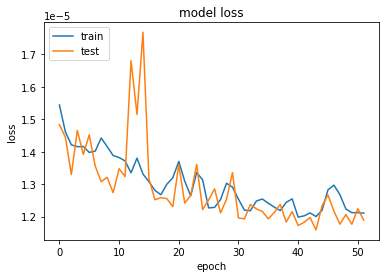

14063/14063 [==============================] - 36s 2ms/step - loss: 2.2067e-05 - val_loss: 1.7598e-05 - lr: 0.0010
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_simple_rnn_8 (QSimpleRNN)  (None, 8)                80        
                                                                 
 q_dense_8 (QDense)          (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14063/14063 [==============================] - 34s 2ms/step - loss: 1.5795e-05 - val_loss: 1.5051e-05 - lr: 0.0010
Epoch 2/200
14063/14063 [==============================] - 32s 2ms/step - loss: 1.5187e-05 - val_loss: 1.5081e-05 - lr: 0.0010
Epoch 3/200
14063/14063 [==============================] - 31s 2ms/step - loss: 1.495

In [10]:
def quantized_model (bits, units_parameter,):  
    losses = []
    checkpoint_filepath = '/atlas/bonnet/Desktop/code/internship_CPPM/rnn/model_checkpoint'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=patience_es, 
                                                    restore_best_weights=True, 
                                                    min_delta=delta,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=patience_rlr, min_lr=0.000001, min_delta=delta, verbose=1)

    val_loss = 1


    # restart training if the model does not start converging by the end of first epoch
    while val_loss > 0.0005:
        qr_model = Sequential()
        qr_model.add(QSimpleRNN(units_parameter,
                            input_dim= 1,
                            activation='relu',
                            kernel_quantizer=quantized_bits(**bits),
                            recurrent_quantizer=quantized_bits(**bits),
                            bias_quantizer=quantized_bits(**bits)    
                            )) 
        qr_model.add(QDense(output, 
                            activation='relu',
                            kernel_quantizer=quantized_bits(**bits),
                            bias_quantizer=quantized_bits(**bits) ))
        qr_model.compile(loss="mse", optimizer=Adam(lr))
        history = qr_model.fit(x, y, validation_data= (x_val,y_val),epochs = 1, batch_size=nbr_batch, shuffle=True, callbacks=[model_checkpoint_callback,early_stopping, reduce_lr,tensorboard_callback])

        val_loss = history.history['val_loss'][0]

        
    qr_model.summary()

    hist = qr_model.fit(x, y, validation_data= (x_val,y_val),epochs =nbr_epoch, batch_size=nbr_batch, shuffle=True, callbacks=[model_checkpoint_callback,early_stopping, reduce_lr,tensorboard_callback])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return qr_model

def qmodel_training (): 

    qmodels =[]
    for i in range(bits_range):
        bits_parameter = bit_width(i)
        for j in range(units_range):
            for v in range(versions_range):
                if (os.path.exists(qtrained_models_path(j,i,v))==False):
                    units_parameter = units(j)
                    qmodel = quantized_model(bits_parameter, units_parameter)
                    qmodel.save(qtrained_models_path(j,i,v))
                    qmodels.append(qmodel)
                else : print(f'{qtrained_models_path(j,i,v)} already exists')
        print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_training()
        

# 3. Compare the results

In [ ]:
loss1 = []
loss2 = []
loss3 = []
bits_nbr = [] 

for i in range(bits_range):
    
    model = qkeras.utils.load_qmodel(qmodels_path(0,i))
    model_ref = qkeras.utils.load_qmodel(f"qmodels_test/qmodels_units={units(0)},<{bit_lenghts(i)},{integer}>.h5")
    bits_nbr.append(bit_lenghts(i))
    y_keras = model.predict(x_test)
    y_qref = model_ref.predict(x_test)
    loss1.append(mse(y_test,y_ref))
    loss2.append(mse(y_test,y_qref))
    loss3.append(mse(y_test,y_keras))

    print ('lossref-loss', (mse(y_test,y_qref)-mse(y_test,y_keras)))
    plt.figure()
    plt.hist(y_test-y_keras, bins=20)
    plt.yscale('log')
    plt.title(f' y_test - y_keras(bits={bit_lenghts(i)}')
    plt.show()

plt.figure()
plt.plot(loss1)
plt.plot(loss2)
plt.plot(loss3)
plt.legend(['ref','qref','qmodel'])
plt.xticks(np.arange(len(bits_nbr)), [f"{bits}" for bits in bits_nbr])
plt.xlabel('bits settings')
plt.ylabel('MSE')
plt.title(f'model trained from scratch, x units')
plt.show()

TypeError: qmodels_path() takes 1 positional argument but 2 were given